## Extension to the Memory-based Recommendation System

__Item-based model__ is widely implemented in recommendation system, however, it is not good enough to merely implement the item-based model. Usually, we need to explore more on the model and combine with some __feature engineering technologies__ and __user behavior analysis__. In this example, we will continue from the previous post, and explore more on the item-based model extensions.

If you haven't check out the previous post, please refer to the following link:

https://medium.com/geekculture/overview-of-item-item-collaborative-filtering-recommendation-system-64ee15b24bb8

### Recap from the previous post

We use the following formula to make prediction.
$$prediction_{u,i} = \frac {\sum_{n}\omega_{i,n}*r_{u,n}}{\sum_{n}\left\lvert {\omega_{i,n}}\right\lvert}$$

### Approach

#### 1. top_n similar items

The original version, we take all of the co-rated user-item rating pairs to make prediction. We can take the top_n similar items only to make prediction. 

The idea of this approach is to eliminate the low similarity rating item's effect on the prediction.

#### 2. Case Amplification

In order to increase the weight of high similarity item's impact, we can use the following equation to amplify the weight, such that $$\omega_{i,u}' = \omega_{i,u} ^ n$$ where $n$ is greater than 1.

In the item-based model, the weight is the similarity between the item-item pair. We will be able to enhance the high similarity impact and punish the low similarity weight.

#### 3. Default Voting

There are a lot of methods in default voting. In this example, we will reduce the weight of user who rated less than n movies.
We will need to explore more from the data aspect to determine the n value.

In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

Let's take the code from the previous code, and we add the __compute_rmse__ function to make our model evaluation easier.

In [2]:
def compute_prediction(userid, itemid, similarity_mtx, utility):
    user_rating = utility.iloc[:,userid-1]
    item_similarity = similarity_mtx[itemid-1]
    numerate = np.dot(user_rating, item_similarity)
    denom = item_similarity[user_rating > 0].sum()
            
    if denom == 0 or numerate == 0:
        return user_rating[user_rating>0].mean()
    
    return numerate / denom

def compute_rmse(test_set, test_real, similarity_mtx, utility, pred_func, **kwargs):
    pred = []
    for data in test_set:
        res = pred_func(userid = data[0], 
                        itemid = data[1], 
                        similarity_mtx = similarity_mtx, 
                        utility = utility, 
                        **kwargs)
        pred.append(res)
    rmse = np.sqrt(np.mean((test_real - pred)**2))
    return rmse


In [3]:
train_path = '../data/ml-100k/u1.base'
test_path = '../data/ml-100k/u1.test'

# load train and test data
df = pd.read_csv(train_path, delimiter = '\t', names = ['userid', 'itemid', 'rating', 'timestamp'])
test = pd.read_csv(test_path, delimiter = '\t', names = ['userid', 'itemid', 'rating', 'timestamp'])
test_set = test[['userid', 'itemid']].to_numpy()
test_real = test['rating'].to_numpy()

# construct the utility matrix
utility = df.pivot(index = 'itemid', columns = 'userid', values = 'rating')
utility = utility.fillna(0)

# calculate the similarity
similarity_mtx = 1 - squareform(pdist(utility, 'cosine'))

The RMSE of the original model is $1.0452369678411928$

In [4]:
compute_rmse(test_set, test_real, similarity_mtx, utility, compute_prediction)

1.0452369678411928

### 1. Top_n similar items

__compute_prediction_v1__ will only take the _top_n_ similar items into account, and make prediction.

Next, we can tune the model by changing the parameter, __top_n__. In our dataset, 17 seems to return the best RMSE. However, we didn't take the __Cross Validation__ in this example. In practice, __Cross Validation__ is essential when training the hyperparameters.

In [5]:
# take the top n similar items
def compute_prediction_v1(userid, itemid, similarity_mtx, utility, top_n):
    user_rating = utility.iloc[:,userid-1]
    item_similarity = similarity_mtx[itemid-1]
    
    # we change the data structure to a list of (user, sim) pairs, and then filter out the non_rated pairs
    user_sim_pair_list = list(zip(user_rating, item_similarity))
    user_sim_pair_list = sorted(filter(lambda x: x[0] != 0 and x[1] != 0, user_sim_pair_list), 
                                key = lambda x: -x[1])[:top_n]

    numerate = sum([x[0] * x[1] for x in user_sim_pair_list])
    denom = sum([x[1] for x in user_sim_pair_list])
            
    if denom == 0 or numerate == 0:
        return user_rating[user_rating>0].mean()
    
    return numerate / denom

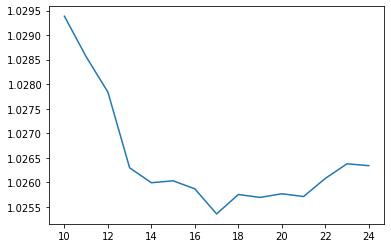

In [6]:
chart_val = []
x_val = list(range(10,25))

for x in x_val:
    rmse = compute_rmse(test_set, test_real, similarity_mtx, utility, compute_prediction_v1, top_n = x)
    chart_val.append([x,rmse])

chart_val_np = np.array(chart_val)
plt.plot(chart_val_np[:, 0], chart_val_np[:,1])

In [7]:
best_model = min(chart_val, key= lambda x: x[1])
print("****************")
print(f'best model:')
print(f'top_n = {best_model[0]}')
print(f'rmse = {best_model[1]}')
print("****************")

****************
best model:
top_n = 17
rmse = 1.0253540271872705
****************


### 2. Case Amplification

In this approach, we further enhance the model based on the approach 1. __compute_prediction_v2__ will take the parameters, _top_n_ and _amp_, where _amp_ refer to the number _n_ in the formula. $$\omega_{i,u}' = \omega_{i,u} ^ n$$

Next, we tune the model and visualize in a graph. As we can see from the graph, 2.5 works best if we take in all the data, it might vary if we change the top_n value.

In [8]:
def compute_prediction_v2(userid, itemid, similarity_mtx, utility, top_n, amp):
    user_rating = utility.iloc[:,userid-1]
    item_similarity = similarity_mtx[itemid-1]
    item_similarity = item_similarity ** amp
    
    # we change the data structure to a list of (user, sim) pairs, and then filter out the non_rated pairs
    user_sim_pair_list = list(zip(user_rating, item_similarity))
    user_sim_pair_list = sorted(filter(lambda x: x[0] != 0 and x[1] != 0, user_sim_pair_list), key = lambda x: -x[1])[:top_n]

    numerate = sum([x[0] * x[1] for x in user_sim_pair_list])
    denom = sum([x[1] for x in user_sim_pair_list])
            
    if denom == 0 or numerate == 0:
        return user_rating[user_rating>0].mean()
    
    return numerate / denom

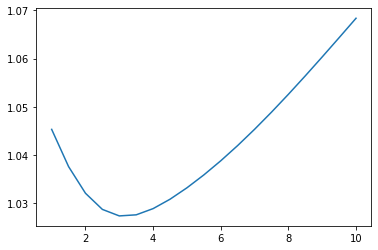

In [9]:
chart_val = []
x_val = np.linspace(1,10,19)

for x in x_val:
    rmse = compute_rmse(test_set, test_real, similarity_mtx, utility, 
                        compute_prediction_v2, 
                        top_n = -1,
                        amp = x)
    chart_val.append([x,rmse])

chart_val_np = np.array(chart_val)
plt.plot(chart_val_np[:, 0], chart_val_np[:,1])

In [10]:
best_model = min(chart_val, key= lambda x: x[1])
print("****************")
print(f'best model:')
print(f'amp = {best_model[0]}')
print(f'rmse = {best_model[1]}')
print("****************")

****************
best model:
amp = 3.0
rmse = 1.0273477985136776
****************


### 3. Default Voting

In this example, we will change the weight of item which receives more than n ratings.

In [11]:
def default_voting_item_amp(df, similarity_mtx, threshold, amp):
    new_sim = deepcopy(similarity_mtx)
    item_count = item_count = df.groupby('itemid').size().reset_index(name='count').sort_values('count')
    amp_item = item_count.loc[item_count['count'] > threshold]['itemid'].to_numpy()
    
    for item in amp_item:
        indx = item - 1
        new_sim[:,indx] *= amp
        new_sim[indx,:] *= amp
    
    return new_sim

#### Dataset Exploration

Before we start defining the hyperparameters, we should take a look at the dataset. As we can see from the plot below, most of items received less than 100 ratings.

Text(0, 0.5, 'number of items')

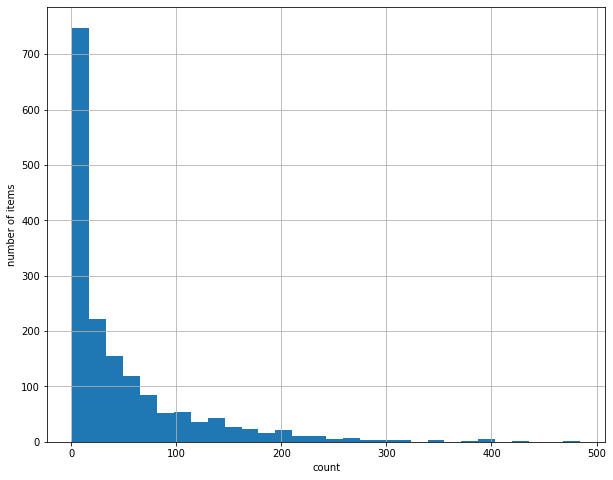

In [12]:
item_count = df.groupby('itemid').size().reset_index(name='count').sort_values('count')
ax = item_count['count'].hist(bins = 30, figsize = (10,8))
ax.set_xlabel('count')
ax.set_ylabel('number of items')

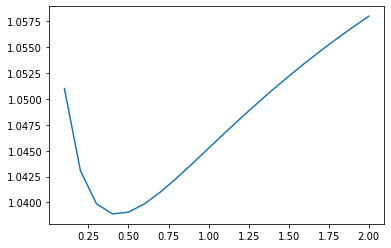

In [13]:
chart_val = []
x_val = np.linspace(0.1, 2, 20)
threshold = 100

for amp in x_val:
    new_sim = default_voting_item_amp(df, similarity_mtx, threshold, amp)
    rmse = compute_rmse(test_set, test_real, new_sim, utility, compute_prediction)
    chart_val.append([amp,rmse])

chart_val_np = np.array(chart_val)
plt.plot(chart_val_np[:, 0], chart_val_np[:,1])

In [14]:
best_model = min(chart_val, key= lambda x: x[1])
print("****************")
print(f'best model:')
print(f'amp = {best_model[0]}')
print(f'rmse = {best_model[1]}')
print("****************")

****************
best model:
amp = 0.4
rmse = 1.0388958637215613
****************
